## Dataset:


> https://esahubble.org/projects/fits_liberator/eagledata/


* **502nmos.zip**: A zip'ped FITS file taken with the NASA/ESA Hubble Space Telescope WFPC2 camera of the star-forming nebula Eagle Nebula through a narrow-band 502 nm filter ([OIII]). 6.33 MB.

* **656nmos.zip**: A zip'ped FITS file taken with the NASA/ESA Hubble Space Telescope WFPC2 camera of the star-forming nebula Eagle Nebula through a narrow-band 656nm filter (H-alpha). 6.24 MB.
* **673nmos.zip**: A zip'ped FITS file taken with the NASA/ESA Hubble Space Telescope WFPC2 camera of the star-forming nebula Eagle Nebula through a narrow-band 673nm filter ([SII]). 6.34 MB.

ASTRONOMICAL IMAGE PROCESSING PIPELINE (Balance) 
Loading red.fits...
Loading green.fits...
Loading blue.fits...

Processing Red (Sulfur) Channel:
  [Red (Sulfur) Stats] Max: 3356.57, Mean Glow: 6.81
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Processing Green (Hydrogen) Channel:
  [Green (Hydrogen) Stats] Max: 3107.17, Mean Glow: 34.59
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Processing Blue (Oxygen) Channel:
  [Blue (Oxygen) Stats] Max: 2919.13, Mean Glow: 3.91
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Combining channels into RGB Image...
  (Using Lupton Stretch to handle the new balanced data)
Displaying final result...
Success! Image saved as eagle_nebula_balanced_final.png


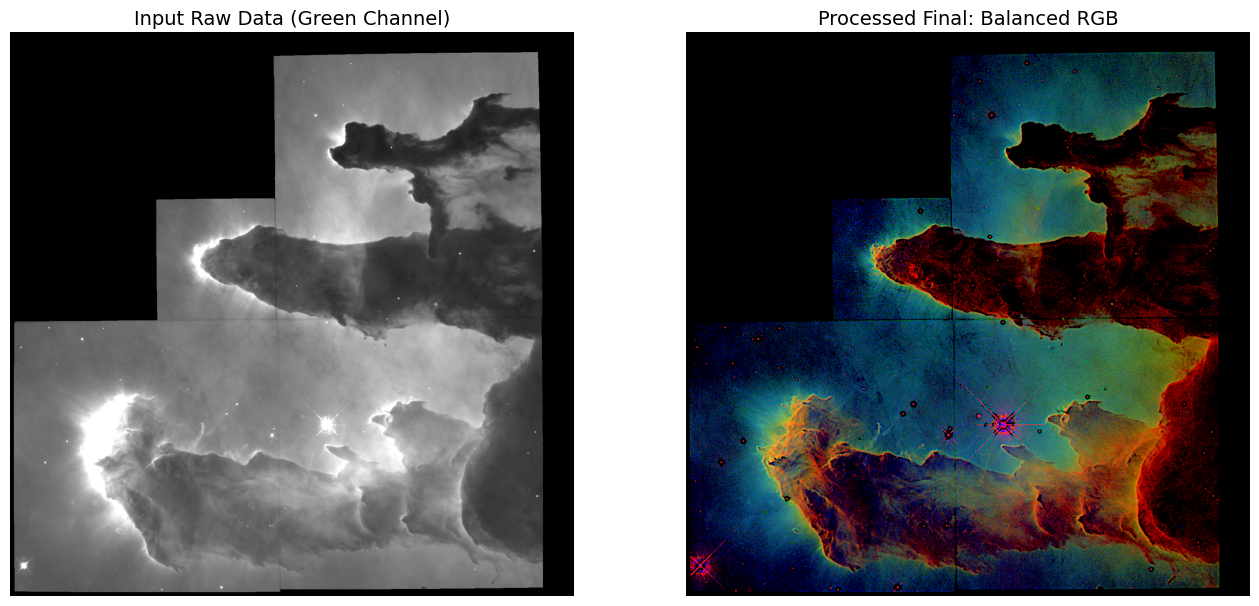

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from scipy.ndimage import gaussian_filter, median_filter

def load_fits_data(filename):
    print(f"Loading {filename}...")
    try:
        data = fits.getdata(filename).astype(float)
        data = np.nan_to_num(data)
        return data
    except FileNotFoundError:
        print(f"ERROR: Could not find {filename}.")
        return None

def aggressive_normalize(data, name="Channel"):

    # 1. Background Subtraction (remove empty space grayness)
    background_level = np.median(data)
    data = data - background_level
    data[data < 0] = 0 # Remove negatives

    # 2. Calculate statistics of the ACTUAL nebula (pixels brighter than background)
    # We look for pixels that are significantly bright (e.g., > 0)
    valid_pixels = data[data > 0]

    if len(valid_pixels) == 0:
        return data # Return empty if no signal

    avg_signal = np.mean(valid_pixels)
    max_signal = np.max(valid_pixels)

    print(f"  [{name} Stats] Max: {max_signal:.2f}, Mean Glow: {avg_signal:.2f}")

    # 3. Scale by the MEAN (Average) brightness
    # This is the key: We make the 'average' glow of every gas equal to 0.2
    # This ensures Blue and Red are boosted significantly to match Green.
    scale_factor = 0.2 / avg_signal
    normalized = data * scale_factor

    # 4. Soft clip to avoid nuclear whiteouts on stars, but let them shine
    # We don't hard clip at 1.0 immediately to preserve star cores for the stretch function
    return normalized

def reduce_noise(data):
    print("  -> Applying Noise Reduction (Median Filter)...")
    return median_filter(data, size=2)

def sharpen_image(data):
    print("  -> Applying Sharpening (Unsharp Mask)...")
    blurred = gaussian_filter(data, sigma=3)
    sharp_mask = data - blurred
    sharpened = data + (sharp_mask * 3.0) # Stronger sharpening
    return sharpened

def run_processing():
    print("ASTRONOMICAL IMAGE PROCESSING PIPELINE (Balance) ")

    r_raw = load_fits_data('red.fits')   # Sulfur
    g_raw = load_fits_data('green.fits') # Hydrogen (The bully)
    b_raw = load_fits_data('blue.fits')  # Oxygen

    if r_raw is None or g_raw is None or b_raw is None:
        return

    processed_channels = []

    # Process each channel
    for name, channel_data in [('Red (Sulfur)', r_raw), ('Green (Hydrogen)', g_raw), ('Blue (Oxygen)', b_raw)]:
        print(f"\nProcessing {name} Channel:")

        # STEP 1: AGGRESSIVE NORMALIZE
        norm_data = aggressive_normalize(channel_data, name)

        # STEP 2: NOISE REDUCTION
        clean_data = reduce_noise(norm_data)

        # STEP 3: SHARPENING
        sharp_data = sharpen_image(clean_data)

        processed_channels.append(sharp_data)

    r_proc, g_proc, b_proc = processed_channels

    print("\nCombining channels into RGB Image...")
    print("  (Using Lupton Stretch to handle the new balanced data)")

    # stretch=0.5: Makes the image brighter
    # Q=8: Preserves color in bright stars
    final_image = make_lupton_rgb(r_proc, g_proc, b_proc, minimum=0, stretch=0.4, Q=8)

    print("Displaying final result...")
    plt.figure(figsize=(16, 8))

    # LEFT: Raw Green (to show what we started with)
    plt.subplot(1, 2, 1)
    plt.title("Input Raw Data (Green Channel)", fontsize=14)
    plt.imshow(g_raw, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(g_raw, 99))
    plt.axis('off')

    # RIGHT: The Final Balanced Image
    plt.subplot(1, 2, 2)
    plt.title("Processed Final: Balanced RGB", fontsize=14)
    plt.imshow(final_image, origin='lower')
    plt.axis('off')

    output_file = 'eagle_nebula_balanced_final.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Success! Image saved as {output_file}")

    plt.show()

if __name__ == "__main__":
    run_processing()

ASTRONOMICAL IMAGE PROCESSING PIPELINE 
Loading red.fits...
Loading green.fits...
Loading blue.fits...

Processing Red (Sulfur) Channel:
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Processing Green (Hydrogen) Channel:
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Processing Blue (Oxygen) Channel:
  -> Applying Noise Reduction (Median Filter)...
  -> Applying Sharpening (Unsharp Mask)...

Combining channels into RGB Image...
Displaying final result...
Success! Image saved as eagle_nebula_corrected.png


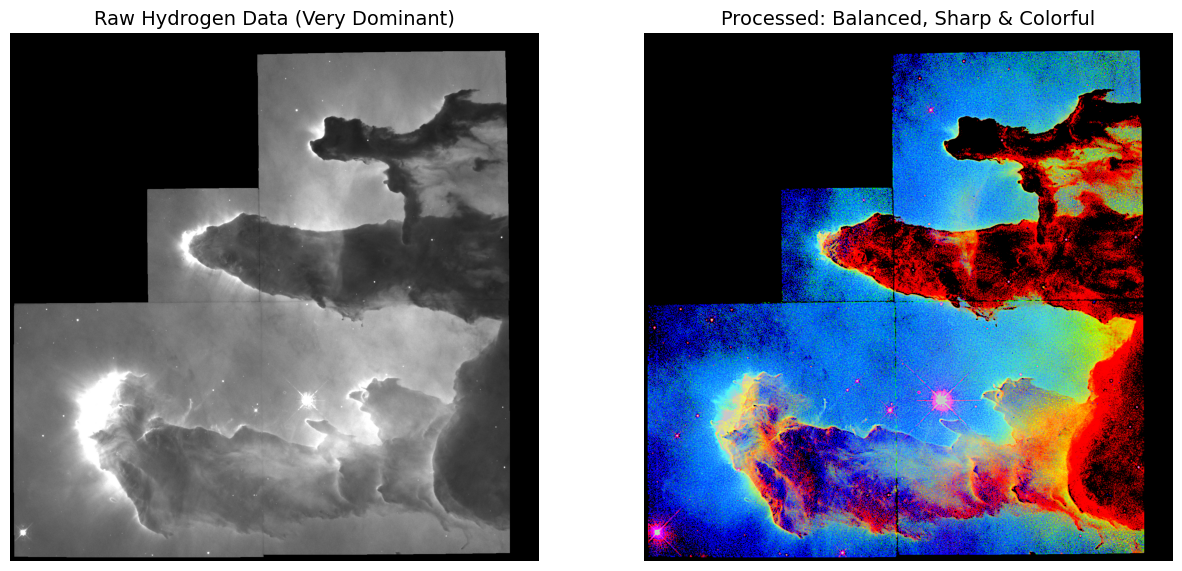

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from scipy.ndimage import gaussian_filter, median_filter

def load_fits_data(filename):
    print(f"Loading {filename}...")
    try:
        data = fits.getdata(filename).astype(float)
        data = np.nan_to_num(data)
        return data
    except FileNotFoundError:
        print(f"ERROR: Could not find {filename}.")
        return None

def normalize_data(data):

    # 1. Background Subtraction: Calculate the median (background) and remove it
    background_level = np.median(data)
    data = data - background_level

    # Clip any negative values created by subtraction to 0
    data[data < 0] = 0

    # 2. Scaling: Divide by the 99th percentile (ignoring the absolute brightest star pixels)
    # This brings faint Sulfur and Oxygen up to the same playing field as bright Hydrogen.
    max_val = np.percentile(data, 99.5)
    if max_val == 0: max_val = 1 # Prevent division by zero

    normalized = data / max_val
    return np.clip(normalized, 0, 1)

def reduce_noise(data):
    print("  -> Applying Noise Reduction (Median Filter)...")
    return median_filter(data, size=2)

def sharpen_image(data):
    print("  -> Applying Sharpening (Unsharp Mask)...")
    blurred = gaussian_filter(data, sigma=3)
    sharp_mask = data - blurred
    sharpened = data + (sharp_mask * 2.0) # Increased strength slightly
    return sharpened

def run_processing():
    print("ASTRONOMICAL IMAGE PROCESSING PIPELINE ")

    r_raw = load_fits_data('red.fits')   # Sulfur
    g_raw = load_fits_data('green.fits') # Hydrogen (The bully)
    b_raw = load_fits_data('blue.fits')  # Oxygen

    if r_raw is None or g_raw is None or b_raw is None:
        return

    processed_channels = []

    # We process AND NORMALIZE each channel now
    for name, channel_data in [('Red (Sulfur)', r_raw), ('Green (Hydrogen)', g_raw), ('Blue (Oxygen)', b_raw)]:
        print(f"\nProcessing {name} Channel:")

        # STEP 1: NORMALIZE (Fixes the Green Blob)
        norm_data = normalize_data(channel_data)

        # STEP 2: NOISE REDUCTION
        clean_data = reduce_noise(norm_data)

        # STEP 3: SHARPENING
        sharp_data = sharpen_image(clean_data)

        processed_channels.append(sharp_data)

    r_proc, g_proc, b_proc = processed_channels

    print("\nCombining channels into RGB Image...")

    # Since we normalized data to 0-1 manually, we adjust Q and stretch here.
    # stretch=0.1 is standard for normalized 0-1 data.
    final_image = make_lupton_rgb(r_proc, g_proc, b_proc, minimum=0, stretch=0.05, Q=8)

    print("Displaying final result...")
    plt.figure(figsize=(15, 10))

    # LEFT: Raw, unscaled Green channel (shows the problem)
    plt.subplot(1, 2, 1)
    plt.title("Raw Hydrogen Data (Very Dominant)", fontsize=14)
    plt.imshow(g_raw, cmap='gray', origin='lower', vmin=0, vmax=np.percentile(g_raw, 99))
    plt.axis('off')

    # RIGHT: The Balanced Color Image
    plt.subplot(1, 2, 2)
    plt.title("Processed: Balanced, Sharp & Colorful", fontsize=14)
    plt.imshow(final_image, origin='lower')
    plt.axis('off')

    output_file = 'eagle_nebula_corrected.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Success! Image saved as {output_file}")

    plt.show()

if __name__ == "__main__":
    run_processing()